In [1]:
# Importing the libraries needed to compute this notebook
# You may need to install xgboost
import yaml
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# Importing clean datasets from yaml file
with open("../../config.yaml", "r") as file:
    config = yaml.safe_load(file)

df_business = pd.read_csv(config['output_data']['business_class_data'])
df_economy = pd.read_csv(config['output_data']['economy_class_data'])
df_bookings = pd.read_csv(config['output_data']['clean_data'])

In [3]:
# DataFrame Overview
df_business.head()

,flight_date,airline_name,flight_code,departure_time,departure_city,arrival_time,arrival_city,flight_duration,stops,price,departure_time_group,arrival_time_group
0,2022-02-11,Air India,AI-868,18:00,Delhi,20:00,Mumbai,120,0,25612,Evening,Evening
1,2022-02-11,Air India,AI-624,19:00,Delhi,21:15,Mumbai,135,0,25612,Evening,Night
2,2022-02-11,Air India,AI-531,20:00,Delhi,20:45,Mumbai,1485,1,42220,Evening,Evening
3,2022-02-11,Air India,AI-839,21:25,Delhi,23:55,Mumbai,1590,1,44450,Night,Night
4,2022-02-11,Air India,AI-544,17:15,Delhi,23:55,Mumbai,400,1,46690,Afternoon,Night


In [4]:
# DTypes Overview
df_business.dtypes

flight_date             object
airline_name            object
flight_code             object
departure_time          object
departure_city          object
arrival_time            object
arrival_city            object
flight_duration          int64
stops                    int64
price                    int64
departure_time_group    object
arrival_time_group      object
dtype: object

In [5]:
df_economy.shape

(206774, 12)

In [6]:
df_business.shape

(93487, 12)

In [7]:
# Checking different airlines offering business class
df_business['airline_name'].value_counts()

airline_name
Vistara      60589
Air India    32898
Name: count, dtype: int64

In [8]:
# Dropping columns that seem too hard to use or redudant (time_group easier to use than time)
columns_to_drop = ['flight_date', 'flight_code', 'departure_time', 'arrival_time']
ml_business = df_business.drop(columns=columns_to_drop)

In [9]:
# Dropping columns that seem too hard to use or redudant (time_group easier to use than time)
columns_to_drop = ['flight_date', 'flight_code', 'departure_time', 'arrival_time']
ml_economy = df_economy.drop(columns=columns_to_drop)

<Axes: ylabel='Density'>

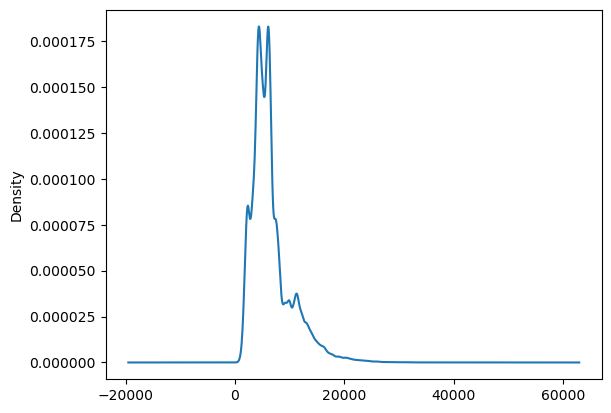

In [10]:
# Looking at price distribution for economy class flights (!!! Price in indian rupees)
df_economy['price'].plot(kind='kde')

<Axes: ylabel='Density'>

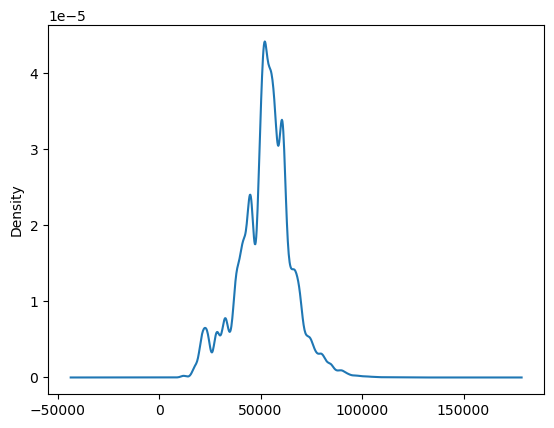

In [11]:
# Looking at price distribution for business class flights (!!! Price in indian rupees)
df_business['price'].plot(kind='kde')

# XGBoost with two separate models and two separate datasets

In [12]:
# Choosing which columns are categorical variables
categorical_columns = ['airline_name', 'departure_city', 'arrival_city']

# Apply one-hot encoding
business_df = pd.get_dummies(ml_business, columns=categorical_columns)
economy_df = pd.get_dummies(ml_economy, columns=categorical_columns)

In [13]:
# Label encode the categorical columns (assuming they are ordinal)
label_encoder = LabelEncoder()

# Apply LabelEncoder to categorical ordinal features
business_df['departure_time_group'] = label_encoder.fit_transform(business_df['departure_time_group'])
economy_df['departure_time_group'] = label_encoder.fit_transform(economy_df['departure_time_group'])

business_df['arrival_time_group'] = label_encoder.fit_transform(business_df['arrival_time_group'])
economy_df['arrival_time_group'] = label_encoder.fit_transform(economy_df['arrival_time_group'])

In [14]:
# This line of code has great power : 
# If you run the notebook with this line commented, the results will be opposite 
# -> 0.3xxx for economy class and 0.8xxx for business class
# The only purpose of this line is to align every categorical feature column in each DataFrame
# e.g. creating columns (filled with 0) for airlines not offering business class seats in the business_df
# business_df, economy_df = economy_df.align(business_df, join='outer', axis=1, fill_value=0)
# I don't have a good explanation for these results sadly ...

In [15]:
# Define target and features
X_business = business_df.drop('price', axis=1)
y_business = business_df['price']

X_economy = economy_df.drop('price', axis=1)
y_economy = economy_df['price']

# Split the data into training and testing sets
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_business, y_business, test_size=0.2, random_state=42)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_economy, y_economy, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xgb_regressor_e = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.5)
xgb_regressor_b = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.5)

# Fit the model for business class
xgb_regressor_b.fit(X_train_b, y_train_b)

# Fit the model for economy class
xgb_regressor_e.fit(X_train_e, y_train_e)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
# Checking that the align function worked correctly (if not commented out)
# economy_df.columns == business_df.columns

In [17]:
# Predict on test data for business class
y_pred_b = xgb_regressor_b.predict(X_test_b)

# Predict on test data for economy class
y_pred_e = xgb_regressor_e.predict(X_test_e)

# Evaluate the model using R2 and RMSE
r2_b = r2_score(y_test_b, y_pred_b)
rmse_b = np.sqrt(mean_squared_error(y_test_b, y_pred_b))

r2_e = r2_score(y_test_e, y_pred_e)
rmse_e = np.sqrt(mean_squared_error(y_test_e, y_pred_e))

print(f"Business Class R²: {r2_b:.4f}")
print(f"Business Class RMSE: {rmse_b:.4f}")

print(f"Economy Class R²: {r2_e:.4f}")
print(f"Economy Class RMSE: {rmse_e:.4f}")


Business Class R²: 0.8561
Business Class RMSE: 4932.6074
Economy Class R²: 0.3603
Economy Class RMSE: 2983.9987


## Results

The results above seem odd. The business model performed correctly for the business class with a R² of 0.86 whereas the performance of economy model for economy class isn't good -> R² of 0.36 BUT way lower RMSE (might be because the price range is lower for economy class).

Such a great difference between the 2 models is hard to understand and could be due to a lot of parameters :
- Hyperparameters tuning : maybe one dataset requires one set of hyperparameters, and the other one requires a different one
- Parameters distribution : we saw before creating our models that the price distribution was (obviously) very different for each class
- Outliers : we didn't compute anything related to outliers except for the price distribution
- Aligning columns when using different models may not be necessary
- Size of datasets : we have way less values for business class than for economy class

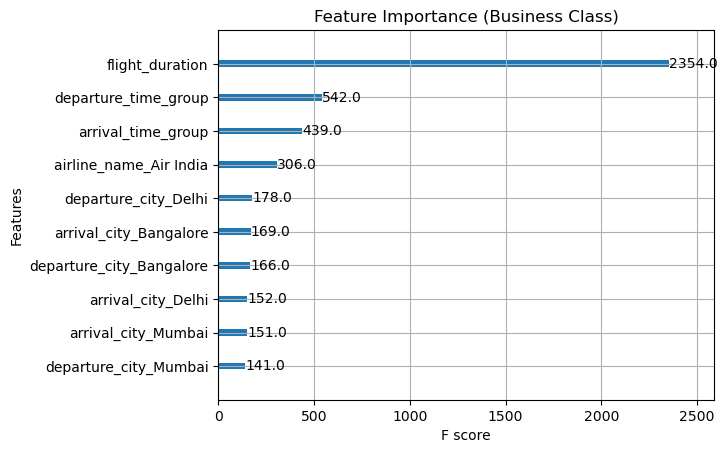

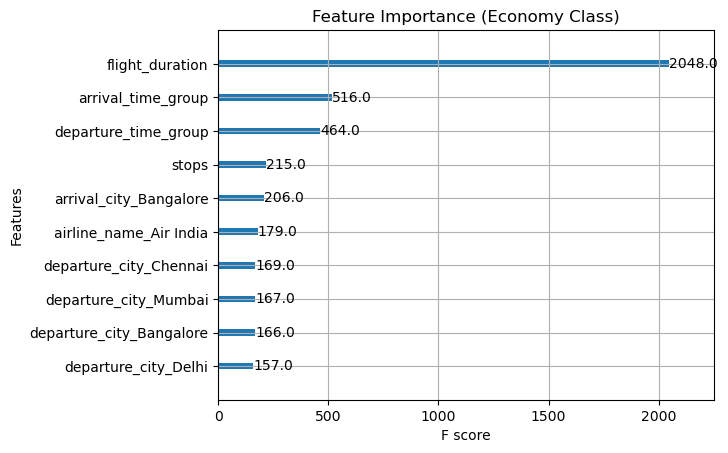

In [18]:
# Plot feature importance for business class
xgboost.plot_importance(xgb_regressor_b, importance_type='weight', max_num_features=10)
plt.title('Feature Importance (Business Class)')
plt.show()

# Plot feature importance for economy class
xgboost.plot_importance(xgb_regressor_e, importance_type='weight', max_num_features=10)
plt.title('Feature Importance (Economy Class)')
plt.show()


## Feature importance

We can see that the airline_name has a greater importance for economy class than for business class. It makes sense because there are much more different airlines in economy class than in business class. It seems weird that Air India particularly takes so much importance in economy class because we saw at the the beginning that it's a company that is also offering business seats.

Below, we'll try another way to compute this problem : XGBoost with one combined dataset and one model

# XGBoost with one combined dataset

In [19]:
# Add a class column to both datasets
ml_business['class']='business'
ml_economy['class']='economy'

# Concatenate the datasets into one containing everything
ml = pd.concat([ml_business, ml_economy], ignore_index=True)

# Shuffle the dataset randomly and reset the index
ml = ml.sample(frac=1)
ml = ml.reset_index(drop=True)
ml.head()

,airline_name,departure_city,arrival_city,flight_duration,stops,price,departure_time_group,arrival_time_group,class
0,Vistara,Kolkata,Delhi,140,0,6489,Evening,Night,economy
1,Vistara,Bangalore,Kolkata,675,2,9017,Morning,Night,economy
2,Air India,Bangalore,Mumbai,475,1,54684,Afternoon,Night,business
3,Air India,Bangalore,Mumbai,310,1,6586,Evening,Late Night,economy
4,Air India,Mumbai,Kolkata,165,0,3177,Evening,Night,economy


In [20]:
# Checking descriptive statistics of the price columns
ml['price'].describe()

count    300261.000000
mean      20883.717666
std       22695.911266
min        1105.000000
25%        4783.000000
50%        7425.000000
75%       42521.000000
max      123071.000000
Name: price, dtype: float64

<Axes: ylabel='Density'>

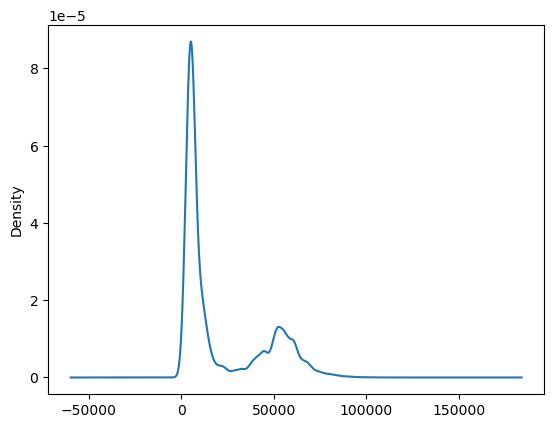

In [21]:
# Confirming what we see in descriptive statistics visually : price isn't normally distributed and it makes sense because there's a high difference
# Between economy class and business class price-wise
ml['price'].plot(kind='kde')

In [22]:
# Separate features in a DataFrame
features = ml.drop(columns='price')
# One Hot Encoding categorical features
dummy_features = pd.get_dummies(features)
# Separate target (price) in a variable
target = ml['price']

# Create training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(dummy_features, target, test_size=0.2, random_state=42)

In [23]:
# Create the same model used before and fit it with our training data
xgb_regressor = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6)
xgb_regressor.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
# Predict on test data
y_pred = xgb_regressor.predict(X_test)

# Evaluate the model using R2 and RMSE
r2 = r2_score(Y_test, y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R²: 0.9661
RMSE: 4172.6590


## Results

The R² Score is very close to 1 (0.97) so this is a very good result. The RMSE is a bit high but if we convert it to euros, that would represent a mean squared error of 22 €. For a squared error, and a price range of 122k indian rupees or 1366 €, it seems fine.

Those results may not be very representative because we used a dataset that was : 
- Unbalanced : 2 times more values for economy class than for business class
- Without a normal price distribution

We'll try using a well-balanced dataset and training another model on it

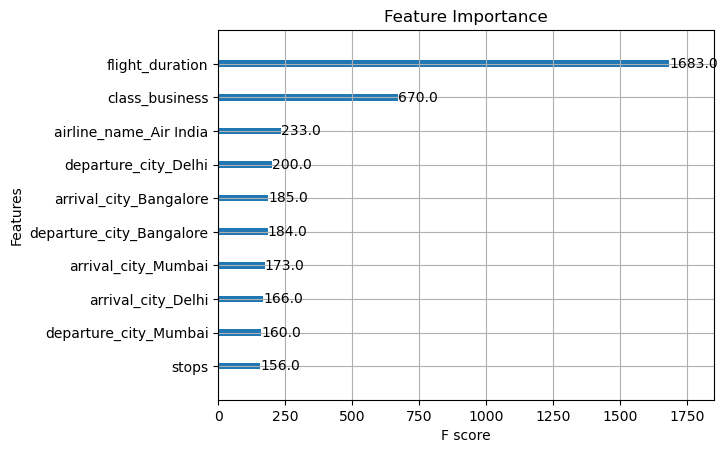

In [25]:
# Plot feature importance
xgboost.plot_importance(xgb_regressor, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()

# Using a balanced dataset to train yet another XGBoost model

In [26]:
# Create another dataset by concatenating 45% of economy dataset and all business dataset (they are rougly the same size)
ml_balanced = pd.concat([ml_business, ml_economy.sample(frac=0.45, random_state=42)])

In [27]:
# Ensuring we have approximatively the same number of values for economy class
ml_balanced[ml_balanced['class'] == 'economy'].shape

(93048, 9)

In [28]:
# And business class
ml_balanced[ml_balanced['class'] == 'business'].shape

(93487, 9)

In [29]:
# Separate features in a DataFrame
features_balanced = ml_balanced.drop(columns='price')
# One Hot Encoding categorical features
dummy_features_balanced = pd.get_dummies(features_balanced)
# Separate target (price) in a variable
target_balanced = ml_balanced['price']

In [30]:
# Create training and testing sets
X_train_balanced, X_test_balanced, Y_train_balanced, Y_test_balanced = train_test_split(dummy_features_balanced, target_balanced, test_size=0.2, random_state=42)

In [31]:
# Create the same model used before and fit it with our balanced training data
xgb_regressor_balanced = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6)
xgb_regressor_balanced.fit(X_train_balanced, Y_train_balanced)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [32]:
# Predict on test data
y_pred_balanced = xgb_regressor_balanced.predict(X_test_balanced)

# Evaluate the model using R2 and RMSE
r2_balanced = r2_score(Y_test_balanced, y_pred_balanced)
rmse_balanced = np.sqrt(mean_squared_error(Y_test_balanced, y_pred_balanced))

print(f"R²: {r2_balanced:.4f}")
print(f"RMSE: {rmse_balanced:.4f}")

R²: 0.9653
RMSE: 4634.4477


## Results 

The results are a tiny bit worse but very similar. We can conclude that with a better balanced dataset, our model still performs really well.